In [1]:
import requests, re, pandas as pd, numpy as np
from itertools import product
from bs4 import BeautifulSoup as bs
from scipy import stats
import pandas as pd
import numpy as np
from datetime import datetime
from xgboost import XGBClassifier, XGBRegressor
import utils
import cleaning, utils
import importlib

importlib.reload(utils)

<module 'utils' from 'Y:\\Internship\\SoMin\\Notebook\\src\\utils.py'>

In [17]:
# ACCESS_TOKEN = 'EAAEau61SMogBAO4Lp0pJaYlJzc67wTychUcwF6gdpLWlet5TqpwnB6k6u0v8DuVAWFaMGO09CQlA7GoOjJnJzTdwzTCO2ZBtCQO721V5U1Qjy5vb7pZCEBC2N5AZAbzVWVYylg1bZCSehy28TTJP7QntMgpxGhD5einLmDxUz3pFfYHPmi47'

In [3]:
import os
import pickle
from datetime import datetime
def ensure_folder_exists(folder_path):
    """
    Creates the specified folder if it does not already exist
    """
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)


def load_pickle(file_path):
    """
    Loads a pickle from the file system
    """
    return pickle.load(open(file_path, 'rb')) if os.path.isfile(file_path) else None


def save_pickle(file_path, data):
    """
    Saves the specified object as a pickle to the file system
    """
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)
        
target = 'Y:/Internship/SoMin/raw/20220523/adlibrary_ads.pkl'
if os.path.getsize(target) > 0: 
    all_ads = load_pickle(target)
    print(len(all_ads))
else:
    print('empty')

38985


In [58]:
FIELDS = ['id','ad_creation_time','ad_delivery_start_time','ad_delivery_stop_time',
          'ad_snapshot_url','ad_creative_bodies','ad_creative_link_captions','ad_creative_link_titles','ad_creative_link_descriptions',
          'languages',
          'page_id','page_name','bylines','currency','spend','impressions','estimated_audience_size','publisher_platforms',
          'demographic_distribution','delivery_by_region']
ACCESS_TOKEN = 'EAAEau61SMogBAGQbTuotGoDcjBfsiRPLzvJYWNVG58idq5jcf4OrFNlwf08aIHtpfTnMLYF6bP7GEjiUkrDRx7fLcvFfdB35zjFfQj84wshfHoNNiuh2ifhpyM4PZAsFzgGywzo6eZCMzk64l353LcykGEkbF8asO9BDSLZBrGL3gvQvtZAE'

def read_endpoint(id_, endpoint, access_token, fields=[], params={}, n=1000000):
    """
    read any endpoint for Facebook Graph API
    
    id_: identifier for any of Business, Account, Campaign, Ad Set, Ad, Creative, Ad Image, Ad Library
    endpoint: endpoint for any of the above according to Facebook Graph API
    access_token: required for usage of Facebook Graph API
    fields: fields to be read for the specified endpoint
    params: parameters to be passed for the specified endpoint
    n: number of desired results to be returned
    """
    q = dict({'access_token': access_token, 'fields': ','.join(fields)}, **params)
    if id_ == '':
        response = request(method='GET', resource=endpoint, q=q)
    else:
        response = request(method='GET', resource=f'{id_}/{endpoint}', q=q)
    if endpoint == '':
        return response
    
    data = []
    while True:
        try:
            data.extend(response['data'])
            if 'next' not in response['paging'].keys():
                break
            if len(data) >= n:
                break
            response = request(method='GET', full_url=response['paging']['next'])
        except Exception as e:
            break # not accessible
    return data



def request(method='GET', full_url='', resource='', q={}):
    """
    resource: Endpoint on FB Graph API
    q: Access Token, Parameters and Fields according to FB Graph API documentation for specified endpoint
    """
    response = None
    if method == 'GET':
        if full_url:
            response = requests.get(full_url)
        if resource:
            response = requests.get(f'https://graph.facebook.com/v13.0/{resource}', q)
        if response.status_code==400:
            print(f'Error Status Code 400 for URL: {response.url}')
            return response
    return response.json()

def obtain_ads(search_term, country, date, fields=FIELDS, access_token=ACCESS_TOKEN):
    """
    a function to obtain ads from Ad Library based on given 'search_page_ids' and 'country'
    """
    params = {'search_terms': search_term,
              'search_type': 'KEYWORD_UNORDERED',
              'ad_active_status': 'ALL',
              'ad_reached_countries': [country],
              'ad_delivery_date_max': date
              'ad_delivery_date_min': date}
    
    ads = read_endpoint('', 'ads_archive', access_token, fields, params, 30000)
    
    for ad in ads: # add additional information
#         ad['search_page_ids'] = page_id 
        ad['topic'] = search_term 
        ad['country'] = country
    return ads

SyntaxError: invalid syntax (<ipython-input-58-375dbe8f58de>, line 69)

In [10]:
ads = obtain_ads("machine-learning", "US")

In [15]:
ads_df = pd.DataFrame(ads)

In [39]:
ads_df

,id,ad_creation_time,ad_delivery_start_time,ad_snapshot_url,ad_creative_bodies,ad_creative_link_captions,ad_creative_link_titles,languages,page_id,page_name,...,currency,spend,impressions,estimated_audience_size,publisher_platforms,demographic_distribution,delivery_by_region,topic,country,ad_delivery_stop_time
0,1046204359628848,2022-05-23,2022-05-23,https://www.facebook.com/a...,[“I knew … how little diff...,[www.ushmm.org],[2022 First Person with Ho...,[en],34362997676,United States Holocaust Me...,...,USD,"{'lower_bound': '400', 'up...","{'lower_bound': '150000', ...",{'lower_bound': '1000001'},[facebook],"[{'percentage': '3.8E-5', ...",[{'percentage': '0.018841'...,machine-learning,US,NaN
1,981212652590224,2022-05-23,2022-05-23,https://www.facebook.com/a...,[How are you navigating in...,NaN,[Navigating Economic Chall...,[en],1959625487618603,Positively West Virginia,...,USD,"{'lower_bound': '0', 'uppe...","{'lower_bound': '0', 'uppe...","{'lower_bound': '500001', ...",[facebook],[{'percentage': '0.031088'...,"[{'percentage': '1', 'regi...",machine-learning,US,2022-05-23
2,3086868414897824,2022-05-19,2022-05-19,https://www.facebook.com/a...,[Oregon's primary election...,[newleafeugene.com],[Get Real W/Rick Dancer & ...,[en],7900929735,Rick Dancer,...,USD,"{'lower_bound': '0', 'uppe...","{'lower_bound': '4000', 'u...",{'lower_bound': '1000001'},"[facebook, instagram]",[{'percentage': '0.001191'...,[{'percentage': '0.083184'...,machine-learning,US,2022-05-23
3,392060789499741,2022-05-16,2022-05-16,https://www.facebook.com/a...,[Join Mike and his special...,NaN,[Mike Crane with the Slate...,[en],244505925600866,Mike Crane,...,USD,"{'lower_bound': '0', 'uppe...","{'lower_bound': '9000', 'u...","{'lower_bound': '50001', '...",[facebook],[{'percentage': '0.000299'...,"[{'percentage': '1', 'regi...",machine-learning,US,2022-05-30
4,1143558803134223,2022-04-06,2022-04-07,https://www.facebook.com/a...,[More scientists are publi...,NaN,[Is Scientific Progress Sl...,[en],192609620649,The University of Chicago,...,USD,"{'lower_bound': '0', 'uppe...","{'lower_bound': '0', 'uppe...",{'lower_bound': '1000001'},"[facebook, instagram]",NaN,NaN,machine-learning,US,NaN
5,447522300461101,2022-03-28,2022-03-29,https://www.facebook.com/a...,[#JoinNOW for a special ep...,NaN,[EP-37! Bonnie Jackson for...,[en],103387475108048,Rimm-PODCAST,...,USD,"{'lower_bound': '0', 'uppe...","{'lower_bound': '3000', 'u...","{'lower_bound': '500001', ...",[facebook],[{'percentage': '0.000922'...,"[{'percentage': '1', 'regi...",machine-learning,US,2022-05-27
6,2407186719425516,2021-05-24,2021-05-25,https://www.facebook.com/a...,"[IP Cams and NVRs, Open Pl...","[ , , , , , , ]","[NDAA Compliant, Amazon Ki...",[en],209980265762811,DWG,...,USD,"{'lower_bound': '300', 'up...","{'lower_bound': '35000', '...",{'lower_bound': '1000001'},[facebook],"[{'percentage': '4.8E-5', ...",[{'percentage': '0.002821'...,machine-learning,US,2022-05-29


In [46]:
ads_23_df = ads_df

In [65]:
ads_18 = obtain_ads("machine-learning", "US", '2022-05-18')
ads_18_df = pd.DataFrame(ads_18)

In [66]:
ads_18_df[['id', 'ad_delivery_start_time', 'ad_delivery_stop_time', 'spend', 'impressions']].sort_values(by=['id'])

,id,ad_delivery_start_time,ad_delivery_stop_time,spend,impressions
10,1032823084031306,2022-04-29,2022-05-20,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '2000', 'upper_bound': '2999'}"
2,1046204359628848,2022-05-23,NaN,"{'lower_bound': '400', 'upper_bound': '499'}","{'lower_bound': '150000', 'upper_bound': '174999'}"
11,1143558803134223,2022-04-07,NaN,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '0', 'upper_bound': '999'}"
5,1222710234931370,2022-05-19,2022-05-21,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '1000', 'upper_bound': '1999'}"
6,1359602351116991,2022-05-19,2022-05-21,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '2000', 'upper_bound': '2999'}"
13,2407186719425516,2021-05-25,2022-05-29,"{'lower_bound': '300', 'upper_bound': '399'}","{'lower_bound': '35000', 'upper_bound': '39999'}"
8,3086868414897824,2022-05-19,2022-05-23,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '4000', 'upper_bound': '4999'}"
9,392060789499741,2022-05-16,2022-05-30,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '9000', 'upper_bound': '9999'}"
1,429889041865333,2022-05-24,2022-05-26,"{'lower_bound': '100', 'upper_bound': '199'}","{'lower_bound': '15000', 'upper_bound': '19999'}"
12,447522300461101,2022-03-29,2022-05-27,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '3000', 'upper_bound': '3999'}"


In [64]:
ads_20_df[['id', 'ad_delivery_start_time', 'ad_delivery_stop_time', 'spend', 'impressions']].sort_values(by=['id'])

,id,ad_delivery_start_time,ad_delivery_stop_time,spend,impressions
10,1032823084031306,2022-04-29,2022-05-20,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '2000', 'upper_bound': '2999'}"
2,1046204359628848,2022-05-23,NaN,"{'lower_bound': '400', 'upper_bound': '499'}","{'lower_bound': '150000', 'upper_bound': '174999'}"
11,1143558803134223,2022-04-07,NaN,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '0', 'upper_bound': '999'}"
5,1222710234931370,2022-05-19,2022-05-21,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '1000', 'upper_bound': '1999'}"
6,1359602351116991,2022-05-19,2022-05-21,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '2000', 'upper_bound': '2999'}"
13,2407186719425516,2021-05-25,2022-05-29,"{'lower_bound': '300', 'upper_bound': '399'}","{'lower_bound': '35000', 'upper_bound': '39999'}"
8,3086868414897824,2022-05-19,2022-05-23,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '4000', 'upper_bound': '4999'}"
9,392060789499741,2022-05-16,2022-05-30,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '9000', 'upper_bound': '9999'}"
1,429889041865333,2022-05-24,2022-05-26,"{'lower_bound': '100', 'upper_bound': '199'}","{'lower_bound': '15000', 'upper_bound': '19999'}"
12,447522300461101,2022-03-29,2022-05-27,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '3000', 'upper_bound': '3999'}"


In [51]:
ads_23_df[['id', 'ad_delivery_start_time', 'ad_delivery_stop_time', 'spend', 'impressions']].sort_values(by=['id'])

,id,ad_delivery_start_time,ad_delivery_stop_time,spend,impressions
0,1046204359628848,2022-05-23,NaN,"{'lower_bound': '400', 'upper_bound': '499'}","{'lower_bound': '150000', 'upper_bound': '174999'}"
4,1143558803134223,2022-04-07,NaN,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '0', 'upper_bound': '999'}"
6,2407186719425516,2021-05-25,2022-05-29,"{'lower_bound': '300', 'upper_bound': '399'}","{'lower_bound': '35000', 'upper_bound': '39999'}"
2,3086868414897824,2022-05-19,2022-05-23,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '4000', 'upper_bound': '4999'}"
3,392060789499741,2022-05-16,2022-05-30,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '9000', 'upper_bound': '9999'}"
5,447522300461101,2022-03-29,2022-05-27,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '3000', 'upper_bound': '3999'}"
1,981212652590224,2022-05-23,2022-05-23,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '0', 'upper_bound': '999'}"


In [52]:
ads_24_df[['id', 'ad_delivery_start_time', 'ad_delivery_stop_time', 'spend', 'impressions']].sort_values(by=['id'])

,id,ad_delivery_start_time,ad_delivery_stop_time,spend,impressions
1,1046204359628848,2022-05-23,NaN,"{'lower_bound': '400', 'upper_bound': '499'}","{'lower_bound': '150000', 'upper_bound': '174999'}"
4,2407186719425516,2021-05-25,2022-05-29,"{'lower_bound': '300', 'upper_bound': '399'}","{'lower_bound': '35000', 'upper_bound': '39999'}"
2,392060789499741,2022-05-16,2022-05-30,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '9000', 'upper_bound': '9999'}"
0,429889041865333,2022-05-24,2022-05-26,"{'lower_bound': '100', 'upper_bound': '199'}","{'lower_bound': '15000', 'upper_bound': '19999'}"
3,447522300461101,2022-03-29,2022-05-27,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '3000', 'upper_bound': '3999'}"


In [57]:
ads_24_2_df[['id', 'ad_delivery_start_time', 'ad_delivery_stop_time', 'spend', 'impressions']].sort_values(by=['id'])

,id,ad_delivery_start_time,ad_delivery_stop_time,spend,impressions
2,1046204359628848,2022-05-23,NaN,"{'lower_bound': '400', 'upper_bound': '499'}","{'lower_bound': '150000', 'upper_bound': '174999'}"
5,2407186719425516,2021-05-25,2022-05-29,"{'lower_bound': '300', 'upper_bound': '399'}","{'lower_bound': '35000', 'upper_bound': '39999'}"
3,392060789499741,2022-05-16,2022-05-30,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '9000', 'upper_bound': '9999'}"
1,429889041865333,2022-05-24,2022-05-26,"{'lower_bound': '100', 'upper_bound': '199'}","{'lower_bound': '15000', 'upper_bound': '19999'}"
4,447522300461101,2022-03-29,2022-05-27,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '3000', 'upper_bound': '3999'}"
0,776349786866202,2022-05-25,NaN,"{'lower_bound': '100', 'upper_bound': '199'}","{'lower_bound': '15000', 'upper_bound': '19999'}"


In [61]:
ads_24_3_df[['id', 'ad_delivery_start_time', 'ad_delivery_stop_time', 'spend', 'impressions']].sort_values(by=['id'])

,id,ad_delivery_start_time,ad_delivery_stop_time,spend,impressions
2,1046204359628848,2022-05-23,NaN,"{'lower_bound': '400', 'upper_bound': '499'}","{'lower_bound': '150000', 'upper_bound': '174999'}"
5,2407186719425516,2021-05-25,2022-05-29,"{'lower_bound': '300', 'upper_bound': '399'}","{'lower_bound': '35000', 'upper_bound': '39999'}"
3,392060789499741,2022-05-16,2022-05-30,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '9000', 'upper_bound': '9999'}"
1,429889041865333,2022-05-24,2022-05-26,"{'lower_bound': '100', 'upper_bound': '199'}","{'lower_bound': '15000', 'upper_bound': '19999'}"
4,447522300461101,2022-03-29,2022-05-27,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '3000', 'upper_bound': '3999'}"
0,776349786866202,2022-05-25,NaN,"{'lower_bound': '100', 'upper_bound': '199'}","{'lower_bound': '15000', 'upper_bound': '19999'}"


In [33]:
ads_24_df

,id,ad_creation_time,ad_delivery_start_time,ad_delivery_stop_time,ad_snapshot_url,ad_creative_bodies,ad_creative_link_captions,ad_creative_link_titles,ad_creative_link_descriptions,languages,...,currency,spend,impressions,estimated_audience_size,publisher_platforms,demographic_distribution,delivery_by_region,topic,country,bylines
0,429889041865333,2022-05-24,2022-05-24,2022-05-26,https://www.facebook.com/a...,[GravityZone Business Secu...,[bitdefender.com/business],[Next-Generation Endpoint ...,[Safeguards your organizat...,[en],...,USD,"{'lower_bound': '100', 'up...","{'lower_bound': '15000', '...",{'lower_bound': '1000001'},[facebook],[{'percentage': '0.002076'...,[{'percentage': '0.026561'...,machine-learning,US,NaN
1,1046204359628848,2022-05-23,2022-05-23,NaN,https://www.facebook.com/a...,[“I knew … how little diff...,[www.ushmm.org],[2022 First Person with Ho...,NaN,[en],...,USD,"{'lower_bound': '400', 'up...","{'lower_bound': '150000', ...",{'lower_bound': '1000001'},[facebook],"[{'percentage': '3.8E-5', ...",[{'percentage': '0.018841'...,machine-learning,US,UNITED STATES HOLOCAUST ME...
2,392060789499741,2022-05-16,2022-05-16,2022-05-30,https://www.facebook.com/a...,[Join Mike and his special...,NaN,[Mike Crane with the Slate...,NaN,[en],...,USD,"{'lower_bound': '0', 'uppe...","{'lower_bound': '9000', 'u...","{'lower_bound': '50001', '...",[facebook],[{'percentage': '0.000299'...,"[{'percentage': '1', 'regi...",machine-learning,US,Tracey Taylor Crane
3,447522300461101,2022-03-28,2022-03-29,2022-05-27,https://www.facebook.com/a...,[#JoinNOW for a special ep...,NaN,[EP-37! Bonnie Jackson for...,NaN,[en],...,USD,"{'lower_bound': '0', 'uppe...","{'lower_bound': '3000', 'u...","{'lower_bound': '500001', ...",[facebook],[{'percentage': '0.000922'...,"[{'percentage': '1', 'regi...",machine-learning,US,Igor Spasojevic
4,2407186719425516,2021-05-24,2021-05-25,2022-05-29,https://www.facebook.com/a...,"[IP Cams and NVRs, Open Pl...","[ , , , , , , ]","[NDAA Compliant, Amazon Ki...",NaN,[en],...,USD,"{'lower_bound': '300', 'up...","{'lower_bound': '35000', '...",{'lower_bound': '1000001'},[facebook],"[{'percentage': '4.8E-5', ...",[{'percentage': '0.002821'...,machine-learning,US,NaN


In [48]:
pd.set_option('display.max_colwidth', 60)

In [25]:
ads_df.iloc[0]

id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [26]:
ads_24_df.iloc[1]

id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [60]:
ads_24_3_df = pd.DataFrame(ads_24_3)
ads_24_3_df

,id,ad_creation_time,ad_delivery_start_time,ad_snapshot_url,ad_creative_bodies,ad_creative_link_captions,ad_creative_link_titles,languages,page_id,page_name,...,spend,impressions,estimated_audience_size,publisher_platforms,demographic_distribution,delivery_by_region,topic,country,ad_delivery_stop_time,ad_creative_link_descriptions
0,776349786866202,2022-05-25,2022-05-25,https://www.facebook.com/ads/archive/render_ad/?id=77634...,"[We've taken some time to level up, and we're back with ...",[www.1hood.org],[What Black Pittsburgh Needs to Know | The State of Poli...,[en],557255760971651,1Hood Media,...,"{'lower_bound': '100', 'upper_bound': '199'}","{'lower_bound': '15000', 'upper_bound': '19999'}","{'lower_bound': '100001', 'upper_bound': '500000'}",[facebook],"[{'percentage': '0.003145', 'age': '55-64', 'gender': 'u...","[{'percentage': '1', 'region': 'Pennsylvania'}]",machine-learning,US,NaN,NaN
1,429889041865333,2022-05-24,2022-05-24,https://www.facebook.com/ads/archive/render_ad/?id=42988...,[GravityZone Business Security Premium safeguards your o...,[bitdefender.com/business],[Next-Generation Endpoint Protection. Evolved.],[en],120189635022,Bitdefender,...,"{'lower_bound': '100', 'upper_bound': '199'}","{'lower_bound': '15000', 'upper_bound': '19999'}",{'lower_bound': '1000001'},[facebook],"[{'percentage': '0.002076', 'age': '35-44', 'gender': 'u...","[{'percentage': '0.026561', 'region': 'Alabama'}, {'perc...",machine-learning,US,2022-05-26,[Safeguards your organization from the full spectrum of ...
2,1046204359628848,2022-05-23,2022-05-23,https://www.facebook.com/ads/archive/render_ad/?id=10462...,[“I knew … how little difference there was between survi...,[www.ushmm.org],[2022 First Person with Holocaust Survivor Allan Firestone],[en],34362997676,United States Holocaust Memorial Museum,...,"{'lower_bound': '400', 'upper_bound': '499'}","{'lower_bound': '150000', 'upper_bound': '174999'}",{'lower_bound': '1000001'},[facebook],"[{'percentage': '3.7E-5', 'age': '18-24', 'gender': 'unk...","[{'percentage': '0.018902', 'region': 'Alabama'}, {'perc...",machine-learning,US,NaN,NaN
3,392060789499741,2022-05-16,2022-05-16,https://www.facebook.com/ads/archive/render_ad/?id=39206...,[Join Mike and his special guests (Candidates for Coweta...,NaN,[Mike Crane with the Slate of Candidates for Coweta Boar...,[en],244505925600866,Mike Crane,...,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '9000', 'upper_bound': '9999'}","{'lower_bound': '50001', 'upper_bound': '100000'}",[facebook],"[{'percentage': '0.000299', 'age': '18-24', 'gender': 'u...","[{'percentage': '1', 'region': 'Georgia'}]",machine-learning,US,2022-05-30,NaN
4,447522300461101,2022-03-28,2022-03-29,https://www.facebook.com/ads/archive/render_ad/?id=44752...,[#JoinNOW for a special episode of Rimm-PODCAST with our...,NaN,[EP-37! Bonnie Jackson for Florida House District-42!],[en],103387475108048,Rimm-PODCAST,...,"{'lower_bound': '0', 'upper_bound': '99'}","{'lower_bound': '3000', 'upper_bound': '3999'}","{'lower_bound': '500001', 'upper_bound': '1000000'}",[facebook],"[{'percentage': '0.000922', 'age': '55-64', 'gender': 'u...","[{'percentage': '1', 'region': 'Florida'}]",machine-learning,US,2022-05-27,NaN
5,2407186719425516,2021-05-24,2021-05-25,https://www.facebook.com/ads/archive/render_ad/?id=24071...,"[IP Cams and NVRs, Open Platform, Easy to use VMS, 180° ...","[ , , , , , , ]","[NDAA Compliant, Amazon Kinesis Video Streams, VAST 2 VM...",[en],209980265762811,DWG,...,"{'lower_bound': '300', 'upper_bound': '399'}","{'lower_bound': '35000', 'upper_bound': '39999'}",{'lower_bound': '1000001'},[facebook],"[{'percentage': '4.8E-5', 'age': '18-24', 'gender': 'unk...","[{'percentage': '0.002821', 'region': 'Delaware'}, {'per...",machine-learning,US,2022-05-29,NaN


In [14]:
df = cleaning.process_ads(all_ads)
df

impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1


impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2


impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2


impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2


impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2


impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2


spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2


impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2


impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2


impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2


impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2


impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2


spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1


impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2


impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2


impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend2


impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2


spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1


impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2


spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2


spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2


spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1


spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1


spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2


impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2


impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1


spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2


impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2


spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1


impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2


impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2


impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2


spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1


impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2


spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2


impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2


impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2


impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2


spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1


impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2


impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2


impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2


impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2


impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2


impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2


spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1


spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2


spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1


impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2


impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1


spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2


spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2


impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2


spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2


impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2


spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2


impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2


impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend1
impressions2
spend2


impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2


impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2


impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2


impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2


impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1


impressions1
spend2
impressions1
spend1
impressions2
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend1
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2
impressions2
spend2


,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,delivery_period,...,CPM,CPM2,impressions2,spend2,CPM3,facebook,instagram,messenger,audience_network,demographic_dist
0,ad-tech,US,100470349235347,Save Texas,762749274711708,2022-05-03,5,2022-05-03,2022-05-06,3,...,33.011004,19.607843,2499,99,39.615846,1,0,0,0,"[{'percentage': '0.004551', 'age': '18-24', 'g..."
1,ad-tech,US,100470349235347,Save Texas,563054608471314,2022-05-03,5,2022-05-03,2022-05-06,3,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.003058', 'age': '45-54', 'g..."
2,ad-tech,US,430964644347524,Campaign Ad-Cloud,930566127614072,2022-05-03,5,2022-05-03,2022-05-08,5,...,49.524762,32.688459,1499,99,66.044029,1,1,0,0,"[{'percentage': '0.001969', 'age': '25-34', 'g..."
3,ad-tech,US,143542762946146,Marcus Murphy,738864343939155,2022-04-07,4,2022-04-07,2022-04-22,15,...,49.524762,32.688459,1499,99,66.044029,1,0,0,0,"[{'percentage': '0.000834', 'age': '45-54', 'g..."
4,ad-tech,US,108510735095059,Dr. Jennifer Wilson for City Council District 5,512240050437223,2022-04-07,4,2022-04-07,2022-04-25,18,...,26.601773,27.922234,12499,349,27.922234,1,1,0,0,"[{'percentage': '0.000944', 'age': '25-34', 'g..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38869,analytics,BR,115255603631922,Ricardo Caminhoneiro 22310,600549173955885,2020-08-27,8,2020-08-27,2020-08-29,2,...,33.011004,19.607843,2499,99,39.615846,1,1,1,0,"[{'percentage': '0.046118', 'age': '35-44', 'g..."
38870,analytics,BR,197246230417092,Superweek - European Analytics Summit,1132843716910980,2019-06-11,6,2019-06-11,2019-06-19,8,...,4.271490,3.830828,64999,249,3.830828,1,0,0,0,"[{'percentage': '0.000264', 'age': '55-64', 'g..."
38871,analytics,BR,197246230417092,Superweek - European Analytics Summit,1409280549253390,2019-06-07,6,2019-06-09,2019-06-11,2,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.395973', 'age': '25-34', 'g..."
38872,analytics,BR,197246230417092,Superweek - European Analytics Summit,2268489546735968,2019-06-07,6,2019-06-09,2019-06-12,3,...,9.900990,5.158438,9499,99,10.422150,1,0,0,0,"[{'percentage': '0.000219', 'age': '18-24', 'g..."


In [4]:
df

,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,delivery_period,...,CPM,CPM2,impressions2,spend2,CPM3,facebook,instagram,messenger,audience_network,demographic_dist
0,ad-tech,US,100470349235347,Save Texas,762749274711708,2022-05-03,5,2022-05-03,2022-05-06,3,...,33.011004,19.607843,2499,99,39.615846,1,0,0,0,"[{'percentage': '0.004551', 'age': '18-24', 'g..."
1,ad-tech,US,100470349235347,Save Texas,563054608471314,2022-05-03,5,2022-05-03,2022-05-06,3,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.003058', 'age': '45-54', 'g..."
2,ad-tech,US,430964644347524,Campaign Ad-Cloud,930566127614072,2022-05-03,5,2022-05-03,2022-05-08,5,...,49.524762,32.688459,1499,99,66.044029,1,1,0,0,"[{'percentage': '0.001969', 'age': '25-34', 'g..."
3,ad-tech,US,143542762946146,Marcus Murphy,738864343939155,2022-04-07,4,2022-04-07,2022-04-22,15,...,49.524762,32.688459,1499,99,66.044029,1,0,0,0,"[{'percentage': '0.000834', 'age': '45-54', 'g..."
4,ad-tech,US,108510735095059,Dr. Jennifer Wilson for City Council District 5,512240050437223,2022-04-07,4,2022-04-07,2022-04-25,18,...,26.601773,27.922234,12499,349,27.922234,1,1,0,0,"[{'percentage': '0.000944', 'age': '25-34', 'g..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38869,analytics,BR,115255603631922,Ricardo Caminhoneiro 22310,600549173955885,2020-08-27,8,2020-08-27,2020-08-29,2,...,33.011004,19.607843,2499,99,39.615846,1,1,1,0,"[{'percentage': '0.046118', 'age': '35-44', 'g..."
38870,analytics,BR,197246230417092,Superweek - European Analytics Summit,1132843716910980,2019-06-11,6,2019-06-11,2019-06-19,8,...,4.271490,3.830828,64999,249,3.830828,1,0,0,0,"[{'percentage': '0.000264', 'age': '55-64', 'g..."
38871,analytics,BR,197246230417092,Superweek - European Analytics Summit,1409280549253390,2019-06-07,6,2019-06-09,2019-06-11,2,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.395973', 'age': '25-34', 'g..."
38872,analytics,BR,197246230417092,Superweek - European Analytics Summit,2268489546735968,2019-06-07,6,2019-06-09,2019-06-12,3,...,9.900990,5.158438,9499,99,10.422150,1,0,0,0,"[{'percentage': '0.000219', 'age': '18-24', 'g..."


In [10]:
df[df.ad_id == '762749274711708']

,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,delivery_period,...,CPM,CPM2,impressions2,spend2,CPM3,facebook,instagram,messenger,audience_network,demographic_dist
0,ad-tech,US,100470349235347,Save Texas,762749274711708,2022-05-03,5,2022-05-03,2022-05-06,3,...,33.011004,19.607843,2499,99,39.615846,1,0,0,0,"[{'percentage': '0.004551', 'age': '18-24', 'g..."


In [18]:
ads_update = utils.obtain_ads_page_id('100470349235347', 'US', access_token=ACCESS_TOKEN)

Error Status Code 400 for URL: https://graph.facebook.com/v13.0/ads_archive?access_token=EAAEau61SMogBAO4Lp0pJaYlJzc67wTychUcwF6gdpLWlet5TqpwnB6k6u0v8DuVAWFaMGO09CQlA7GoOjJnJzTdwzTCO2ZBtCQO721V5U1Qjy5vb7pZCEBC2N5AZAbzVWVYylg1bZCSehy28TTJP7QntMgpxGhD5einLmDxUz3pFfYHPmi47&fields=id%2Cad_creation_time%2Cad_delivery_start_time%2Cad_delivery_stop_time%2Cad_snapshot_url%2Cad_creative_bodies%2Cad_creative_link_captions%2Cad_creative_link_titles%2Cad_creative_link_descriptions%2Clanguages%2Cpage_id%2Cpage_name%2Cbylines%2Ccurrency%2Cspend%2Cimpressions%2Cestimated_audience_size%2Cpublisher_platforms%2Cdemographic_distribution%2Cdelivery_by_region&search_page_ids=100470349235347&media_type=IMAGE&ad_active_status=ALL&ad_reached_countries=US


In [14]:
ads_update

[{'id': '740015123855412',
  'ad_creation_time': '2022-05-22',
  'ad_delivery_start_time': '2022-05-22',
  'ad_snapshot_url': 'https://www.facebook.com/ads/archive/render_ad/?id=740015123855412&access_token=EAAEau61SMogBAKXf5ZCiYZC2WkmfCAkZCEz1cQoZBTgg4AdxRAAmG5ZAcH8hrSEsXPDZBPFodOdKr7s49i4ZBecZAZBnnV86z5HMCZAaYp1s2WoUj5P5PzYXTX6Gao2awkZBBudMZBubxwlG3UeRUZBCsBTb5GCeHbAsJFdf0Bal6Rpou4ORNt56cpVpK',
  'ad_creative_bodies': ['Fossil fuel exporters are driving up monthly gas and electricity bills for American families.  The more they export, the more we pay.  #SaveTexas'],
  'ad_creative_link_captions': ['facebook.com'],
  'ad_creative_link_titles': ['Save Texas'],
  'ad_creative_link_descriptions': ['Save Texas!'],
  'languages': ['en'],
  'page_id': '100470349235347',
  'page_name': 'Save Texas',
  'bylines': 'Texas Campaign for the Environment',
  'currency': 'USD',
  'spend': {'lower_bound': '200', 'upper_bound': '299'},
  'impressions': {'lower_bound': '15000', 'upper_bound': '19999'},

In [16]:
ads_update_df = cleaning.process_ads2(ads_update)

impressions1
spend1
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions2
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2
impressions1
spend2


In [19]:
ads_update_df[ads_update_df['ad_id'] == '762749274711708'].iloc[0]

country                                                             US
page_id                                                100470349235347
page_name                                                   Save Texas
ad_id                                                  762749274711708
ad_creation_date                                            2022-05-03
ad_creation_month                                                    5
delivery_start                                              2022-05-03
delivery_stop                                               2022-05-06
delivery_period                                                      3
ad_url               https://www.facebook.com/ads/archive/render_ad...
ad_body              In a technical report updated for the first ti...
uses_multi_body                                                      0
link_caption                                     oceanservice.noaa.gov
uses_multi_capt                                                      0
link_t

In [20]:
df[df['ad_id'] == '762749274711708'].iloc[0]

search_term                                                    ad-tech
country                                                             US
page_id                                                100470349235347
page_name                                                   Save Texas
ad_id                                                  762749274711708
ad_creation_date                                            2022-05-03
ad_creation_month                                                    5
delivery_start                                              2022-05-03
delivery_stop                                               2022-05-06
delivery_period                                                      3
ad_url               https://www.facebook.com/ads/archive/render_ad...
ad_body              In a technical report updated for the first ti...
uses_multi_body                                                      0
link_caption                                     oceanservice.noaa.gov
uses_m

In [5]:
def process_ads(ads):
    """
    processes Ads retrieved from Ads Archive (FB Ad Library)
    """
    df = pd.DataFrame(ads)    
    clean = []
    for _, row in df.iterrows():
        m = {}
        m['search_term'] = row['topic']
        m['country'] = row['country']
        m['page_id'] = row['page_id']
        m['page_name'] = row['page_name']
        m['ad_id'] = row['id']
        
        m['ad_creation_date'] = row['ad_creation_time']
        if m['ad_creation_date'] is np.nan:
            continue
        m['ad_creation_month'] = int(m['ad_creation_date'][5:7])
        
        
        m['delivery_start'] = row['ad_delivery_start_time']
        if m['delivery_start'] is np.nan:
            continue
            
        m['delivery_stop'] = row['ad_delivery_stop_time']
#         if m['delivery_stop'] is np.nan:
#             continue
        
#         start = datetime.strptime(m['delivery_start'], '%Y-%m-%d')
#         stop = datetime.strptime(m['delivery_stop'], '%Y-%m-%d')
#         m['delivery_period'] = (stop-start).days
        
        m['ad_url'] = row['ad_snapshot_url']
        
#         try:
#             source = soup(requests.get(row['ad_snapshot_url']).content, 'html.parser')
#             m['image_url'] = get_image_url(source)
#         except:
#             m['image_url'] = np.nan # some ads are wrongly classified as having images
        
        ad_body = row['ad_creative_bodies']
        m['ad_body'] = ad_body[0] if (type(ad_body) == list) else ''
        m['uses_multi_body'] = 1 if ((type(ad_body) == list) and (len(set(ad_body)) > 1)) else 0
        
        link_capt = row['ad_creative_link_captions']
        m['link_caption'] = link_capt[0] if (type(link_capt) == list) else ''
        m['uses_multi_capt'] = 1 if ((type(link_capt) == list) and (len(set(link_capt)) > 1)) else 0
        
        link_title = row['ad_creative_link_titles']
        m['link_title'] = link_title[0] if (type(link_title) == list) else ''
        m['uses_multi_title'] = 1 if ((type(link_title) == list) and (len(set(link_title)) > 1)) else 0
        
        link_desc = row['ad_creative_link_descriptions']
        m['link_description'] = link_desc[0] if (type(link_desc) == list) else ''
        m['uses_multi_desc'] = 1 if ((type(link_desc) == list) and (len(set(link_desc)) > 1)) else 0
        
        lang = row['languages']
        m['language'] = ','.join(lang) if (type(lang) == list) else ''
        m['uses_multi_lang'] = 1 if ((type(lang) == list) and (len(set(lang)) > 1)) else 0
        
        m['funded_by'] = row['bylines'] if type(row['bylines']) == str else ''
        m['currency'] = row['currency']
        
        spend = row['spend']
        m['min_spend'] = spend.get('lower_bound', np.nan)
        m['max_spend'] = spend.get('upper_bound', np.nan)
        
        impressions = row['impressions']
        m['min_impressions'] = impressions.get('lower_bound', np.nan)
        m['max_impressions'] = impressions.get('upper_bound', np.nan)
        
        audience_size = row['estimated_audience_size']
        m['min_audience_size'] = audience_size.get('lower_bound', np.nan) if type(audience_size)==dict else np.nan
        m['max_audience_size'] = audience_size.get('upper_bound', np.nan) if type(audience_size)==dict else np.nan
        
        
        if m['max_impressions'] is np.nan or m['min_impressions'] is np.nan: 
            m['impressions'] = 0
            continue
        else:
            m['impressions'] = (int(m['max_impressions']) + int(m['min_impressions']))/2
            
        if m['max_spend'] is np.nan or m['min_spend'] is np.nan: 
            m['spend'] = 0
            continue
        else:
            m['spend'] = (int(m['max_spend']) + int(m['min_spend']))/2
        
        
        if m['max_impressions'] is np.nan or m['max_impressions'] == 0:
            m['CPM'] = 0
            continue
        else:
            m['CPM'] = int(m['max_spend']) / int(m['max_impressions']) * 1000
        
        if m['max_impressions'] is np.nan or m['max_impressions'] == 0:
            m['CPM2'] = 0
            continue
        else:
            m['CPM2'] = int(m['spend']) / int(m['impressions']) * 1000
        
        
        ### get rid of 0 value
        
        if m['max_impressions'] is np.nan or m['min_impressions'] is np.nan: 
            m['impressions2'] = 0
            continue
        else:
            if int(m['min_impressions']) != 0:
#                 print('impressions1')
                m['impressions2'] = (int(m['max_impressions']) + int(m['min_impressions']))/2
            else:
#                 print('impressions2')
                m['impressions2'] = m['max_impressions']
            
        if m['max_spend'] is np.nan or m['min_spend'] is np.nan: 
            m['spend2'] = 0
            continue
        else:
            if int(m['min_spend'])!=0:
#                 print('spend1')
                m['spend2'] = (int(m['max_spend']) + int(m['min_spend']))/2
            else:
#                 print('spend2')
                m['spend2'] = m['max_spend']
               
        #CPM3
        if m['max_impressions'] is np.nan or m['max_impressions'] == 0:
            m['CPM3'] = 0
            continue
        else:
            m['CPM3'] = int(m['spend2']) / int(m['impressions2']) * 1000
                
        
        
        platforms = row['publisher_platforms']
        m['facebook'] = 1 if ((type(platforms) == list) and ('facebook' in platforms)) else 0
        m['instagram'] = 1 if ((type(platforms) == list) and ('instagram' in platforms)) else 0
        m['messenger'] = 1 if ((type(platforms) == list) and ('messenger' in platforms)) else 0
        m['audience_network'] = 1 if ((type(platforms) == list) and ('audience_network' in platforms)) else 0
        
        m['demographic_dist'] = row['demographic_distribution']
        clean.append(m)
    
    df = pd.DataFrame(clean)
    df['min_spend']=df['min_spend'].astype('int64')
    df['max_spend']=df['max_spend'].astype('int64')
    df['min_impressions']=df['min_impressions'].astype('int64')
    df['max_impressions']=df['max_impressions'].astype('int64')
    
    df['impressions']=df['impressions'].astype('int64')
    df['impressions2']=df['impressions2'].astype('int64')
    df['spend']=df['spend'].astype('int64')
    df['spend2']=df['spend2'].astype('int64')


    df['country']=df['country'].astype('category')
    df['search_term']=df['search_term'].astype('category')
    
    
    return df

In [6]:
df2 = process_ads(all_ads)

In [7]:
df2

,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,ad_url,...,CPM,CPM2,impressions2,spend2,CPM3,facebook,instagram,messenger,audience_network,demographic_dist
0,ad-tech,US,100470349235347,Save Texas,762749274711708,2022-05-03,5,2022-05-03,2022-05-06,https://www.facebook.com/ads/archive/render_ad...,...,33.011004,19.607843,2499,99,39.615846,1,0,0,0,"[{'percentage': '0.004551', 'age': '18-24', 'g..."
1,ad-tech,US,100470349235347,Save Texas,563054608471314,2022-05-03,5,2022-05-03,2022-05-06,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.003058', 'age': '45-54', 'g..."
2,ad-tech,US,430964644347524,Campaign Ad-Cloud,930566127614072,2022-05-03,5,2022-05-03,2022-05-08,https://www.facebook.com/ads/archive/render_ad...,...,49.524762,32.688459,1499,99,66.044029,1,1,0,0,"[{'percentage': '0.001969', 'age': '25-34', 'g..."
3,ad-tech,US,143542762946146,Marcus Murphy,738864343939155,2022-04-07,4,2022-04-07,2022-04-22,https://www.facebook.com/ads/archive/render_ad...,...,49.524762,32.688459,1499,99,66.044029,1,0,0,0,"[{'percentage': '0.000834', 'age': '45-54', 'g..."
4,ad-tech,US,108510735095059,Dr. Jennifer Wilson for City Council District 5,512240050437223,2022-04-07,4,2022-04-07,2022-04-25,https://www.facebook.com/ads/archive/render_ad...,...,26.601773,27.922234,12499,349,27.922234,1,1,0,0,"[{'percentage': '0.000944', 'age': '25-34', 'g..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38925,analytics,BR,115255603631922,Ricardo Caminhoneiro 22310,600549173955885,2020-08-27,8,2020-08-27,2020-08-29,https://www.facebook.com/ads/archive/render_ad...,...,33.011004,19.607843,2499,99,39.615846,1,1,1,0,"[{'percentage': '0.046118', 'age': '35-44', 'g..."
38926,analytics,BR,197246230417092,Superweek - European Analytics Summit,1132843716910980,2019-06-11,6,2019-06-11,2019-06-19,https://www.facebook.com/ads/archive/render_ad...,...,4.271490,3.830828,64999,249,3.830828,1,0,0,0,"[{'percentage': '0.000264', 'age': '55-64', 'g..."
38927,analytics,BR,197246230417092,Superweek - European Analytics Summit,1409280549253390,2019-06-07,6,2019-06-09,2019-06-11,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.395973', 'age': '25-34', 'g..."
38928,analytics,BR,197246230417092,Superweek - European Analytics Summit,2268489546735968,2019-06-07,6,2019-06-09,2019-06-12,https://www.facebook.com/ads/archive/render_ad...,...,9.900990,5.158438,9499,99,10.422150,1,0,0,0,"[{'percentage': '0.000219', 'age': '18-24', 'g..."


In [8]:
df2.iloc[0]

search_term                                                    ad-tech
country                                                             US
page_id                                                100470349235347
page_name                                                   Save Texas
ad_id                                                  762749274711708
ad_creation_date                                            2022-05-03
ad_creation_month                                                    5
delivery_start                                              2022-05-03
delivery_stop                                               2022-05-06
ad_url               https://www.facebook.com/ads/archive/render_ad...
ad_body              In a technical report updated for the first ti...
uses_multi_body                                                      0
link_caption                                     oceanservice.noaa.gov
uses_multi_capt                                                      0
link_t

In [12]:
df3 = df2
df4 = df3[df3['delivery_stop'].isna()]

In [14]:
df4

,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,ad_url,...,CPM,CPM2,impressions2,spend2,CPM3,facebook,instagram,messenger,audience_network,demographic_dist
353,ed-tech,US,1431889706937050,Free & Fair Markets Initiative,2762194074076730,2022-04-29,4,2022-05-01,NaN,https://www.facebook.com/ads/archive/render_ad...,...,19.803961,10.891309,4499,99,22.004890,1,1,0,0,"[{'percentage': '0.001177', 'age': '25-34', 'g..."
354,ed-tech,US,1431889706937050,Free & Fair Markets Initiative,1729604084044789,2022-04-29,4,2022-05-01,NaN,https://www.facebook.com/ads/archive/render_ad...,...,33.011004,19.607843,2499,99,39.615846,1,1,0,0,"[{'percentage': '0.002766', 'age': '65+', 'gen..."
1416,electric-vehicles,US,104178704279594,Main St. First,681506836245171,2022-05-22,5,2022-05-22,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,NaN
1417,electric-vehicles,US,108620667163768,For Our Future,366262202140520,2022-05-22,5,2022-05-22,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,NaN
1418,electric-vehicles,US,125179374733697,Big News Buzz,722062319142320,2022-05-22,5,2022-05-22,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,NaN
1432,electric-vehicles,US,6204742571,Sierra Club,519721129770217,2022-04-08,4,2022-04-08,NaN,https://www.facebook.com/ads/archive/render_ad...,...,5.980120,5.242216,47499,249,5.242216,1,1,0,0,"[{'percentage': '3.5E-5', 'age': '13-17', 'gen..."
1443,electric-vehicles,US,105576028300637,Building Back Together,510037094149689,2022-03-22,3,2022-03-22,NaN,https://www.facebook.com/ads/archive/render_ad...,...,4.983416,4.527355,54999,249,4.527355,1,1,0,0,"[{'percentage': '0.000161', 'age': '13-17', 'g..."
3745,clean-energy,US,450525781774645,Ohio Conservative Energy Forum,1157908801668008,2022-05-19,5,2022-05-19,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,1,0,0,"[{'percentage': '0.074074', 'age': '45-54', 'g..."
3746,clean-energy,US,1521463681450292,IL CleanJobs,746413549718018,2022-05-19,5,2022-05-19,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,1,0,0,"[{'percentage': '0.035714', 'age': '25-34', 'g..."
3747,clean-energy,US,90022052772,Williams,760010165164801,2022-05-19,5,2022-05-21,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,1,0,0,NaN


In [16]:
df4.index = range(df4.shape[0])
df4

,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,ad_url,...,CPM,CPM2,impressions2,spend2,CPM3,facebook,instagram,messenger,audience_network,demographic_dist
0,ed-tech,US,1431889706937050,Free & Fair Markets Initiative,2762194074076730,2022-04-29,4,2022-05-01,NaN,https://www.facebook.com/ads/archive/render_ad...,...,19.803961,10.891309,4499,99,22.004890,1,1,0,0,"[{'percentage': '0.001177', 'age': '25-34', 'g..."
1,ed-tech,US,1431889706937050,Free & Fair Markets Initiative,1729604084044789,2022-04-29,4,2022-05-01,NaN,https://www.facebook.com/ads/archive/render_ad...,...,33.011004,19.607843,2499,99,39.615846,1,1,0,0,"[{'percentage': '0.002766', 'age': '65+', 'gen..."
2,electric-vehicles,US,104178704279594,Main St. First,681506836245171,2022-05-22,5,2022-05-22,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,NaN
3,electric-vehicles,US,108620667163768,For Our Future,366262202140520,2022-05-22,5,2022-05-22,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,NaN
4,electric-vehicles,US,125179374733697,Big News Buzz,722062319142320,2022-05-22,5,2022-05-22,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,NaN
5,electric-vehicles,US,6204742571,Sierra Club,519721129770217,2022-04-08,4,2022-04-08,NaN,https://www.facebook.com/ads/archive/render_ad...,...,5.980120,5.242216,47499,249,5.242216,1,1,0,0,"[{'percentage': '3.5E-5', 'age': '13-17', 'gen..."
6,electric-vehicles,US,105576028300637,Building Back Together,510037094149689,2022-03-22,3,2022-03-22,NaN,https://www.facebook.com/ads/archive/render_ad...,...,4.983416,4.527355,54999,249,4.527355,1,1,0,0,"[{'percentage': '0.000161', 'age': '13-17', 'g..."
7,clean-energy,US,450525781774645,Ohio Conservative Energy Forum,1157908801668008,2022-05-19,5,2022-05-19,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,1,0,0,"[{'percentage': '0.074074', 'age': '45-54', 'g..."
8,clean-energy,US,1521463681450292,IL CleanJobs,746413549718018,2022-05-19,5,2022-05-19,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,1,0,0,"[{'percentage': '0.035714', 'age': '25-34', 'g..."
9,clean-energy,US,90022052772,Williams,760010165164801,2022-05-19,5,2022-05-21,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,1,0,0,NaN


In [20]:
on_going_ad

,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,ad_url,...,CPM,CPM2,impressions2,spend2,CPM3,facebook,instagram,messenger,audience_network,demographic_dist
0,ed-tech,US,1431889706937050,Free & Fair Markets Initiative,2762194074076730,2022-04-29,4,2022-05-01,NaN,https://www.facebook.com/ads/archive/render_ad...,...,19.803961,10.891309,4499,99,22.004890,1,1,0,0,"[{'percentage': '0.001177', 'age': '25-34', 'g..."
1,ed-tech,US,1431889706937050,Free & Fair Markets Initiative,1729604084044789,2022-04-29,4,2022-05-01,NaN,https://www.facebook.com/ads/archive/render_ad...,...,33.011004,19.607843,2499,99,39.615846,1,1,0,0,"[{'percentage': '0.002766', 'age': '65+', 'gen..."
2,electric-vehicles,US,104178704279594,Main St. First,681506836245171,2022-05-22,5,2022-05-22,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,NaN
3,electric-vehicles,US,108620667163768,For Our Future,366262202140520,2022-05-22,5,2022-05-22,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,NaN
4,electric-vehicles,US,125179374733697,Big News Buzz,722062319142320,2022-05-22,5,2022-05-22,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,NaN
5,electric-vehicles,US,6204742571,Sierra Club,519721129770217,2022-04-08,4,2022-04-08,NaN,https://www.facebook.com/ads/archive/render_ad...,...,5.980120,5.242216,47499,249,5.242216,1,1,0,0,"[{'percentage': '3.5E-5', 'age': '13-17', 'gen..."
6,electric-vehicles,US,105576028300637,Building Back Together,510037094149689,2022-03-22,3,2022-03-22,NaN,https://www.facebook.com/ads/archive/render_ad...,...,4.983416,4.527355,54999,249,4.527355,1,1,0,0,"[{'percentage': '0.000161', 'age': '13-17', 'g..."
7,clean-energy,US,450525781774645,Ohio Conservative Energy Forum,1157908801668008,2022-05-19,5,2022-05-19,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,1,0,0,"[{'percentage': '0.074074', 'age': '45-54', 'g..."
8,clean-energy,US,1521463681450292,IL CleanJobs,746413549718018,2022-05-19,5,2022-05-19,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,1,0,0,"[{'percentage': '0.035714', 'age': '25-34', 'g..."
9,clean-energy,US,90022052772,Williams,760010165164801,2022-05-19,5,2022-05-21,NaN,https://www.facebook.com/ads/archive/render_ad...,...,99.099099,98.196393,999,99,99.099099,1,1,0,0,NaN


In [21]:
ads = utils.obtain_ads_page_id('1431889706937050', 'US')

In [36]:
on_going_ad = np.array(on_going_ad)

In [38]:
for ad in on_going_ad:
    if ad['ad_id'] == '2762194074076730':
        print(ad['delivery_stop'])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
on_going_ad = df3[df3['delivery_stop'].isna()].drop_duplicates(subset = ['page_id'])
on_going_ad.index = range(on_going_ad.shape[0])
update_ongoing_ads = []
for i in range(on_going_ad.shape[0]):
    print(on_going_ad.iloc[i].ad_id, on_going_ad.iloc[i].page_id)
    ads = utils.obtain_ads_page_id(on_going_ad.iloc[i].page_id, 'US')
    print(f'Retrieve {len(ads)} ads')
    all_ads.extend(ads)
#     update_ongoing_ads.extend(ad for ad in np.array(ads) if ad['ad_id'] == on_going_ad.iloc[i].ad_id)

2762194074076730 1431889706937050
Retrieve 37 ads
681506836245171 104178704279594
Retrieve 1147 ads
366262202140520 108620667163768
Retrieve 975 ads
722062319142320 125179374733697


In [ ]:
update

In [31]:
ad_update_ongoing_ads[1]

<generator object <genexpr> at 0x00000233B6A7E900>

In [20]:
df4 = df
df4

,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,delivery_period,...,CPM,CPM2,impressions2,spend2,CPM3,facebook,instagram,messenger,audience_network,demographic_dist
0,ad-tech,US,100470349235347,Save Texas,762749274711708,2022-05-03,5,2022-05-03,2022-05-06,3,...,33.011004,19.607843,2499,99,39.615846,1,0,0,0,"[{'percentage': '0.004551', 'age': '18-24', 'g..."
1,ad-tech,US,100470349235347,Save Texas,563054608471314,2022-05-03,5,2022-05-03,2022-05-06,3,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.003058', 'age': '45-54', 'g..."
2,ad-tech,US,430964644347524,Campaign Ad-Cloud,930566127614072,2022-05-03,5,2022-05-03,2022-05-08,5,...,49.524762,32.688459,1499,99,66.044029,1,1,0,0,"[{'percentage': '0.001969', 'age': '25-34', 'g..."
3,ad-tech,US,143542762946146,Marcus Murphy,738864343939155,2022-04-07,4,2022-04-07,2022-04-22,15,...,49.524762,32.688459,1499,99,66.044029,1,0,0,0,"[{'percentage': '0.000834', 'age': '45-54', 'g..."
4,ad-tech,US,108510735095059,Dr. Jennifer Wilson for City Council District 5,512240050437223,2022-04-07,4,2022-04-07,2022-04-25,18,...,26.601773,27.922234,12499,349,27.922234,1,1,0,0,"[{'percentage': '0.000944', 'age': '25-34', 'g..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38869,analytics,BR,115255603631922,Ricardo Caminhoneiro 22310,600549173955885,2020-08-27,8,2020-08-27,2020-08-29,2,...,33.011004,19.607843,2499,99,39.615846,1,1,1,0,"[{'percentage': '0.046118', 'age': '35-44', 'g..."
38870,analytics,BR,197246230417092,Superweek - European Analytics Summit,1132843716910980,2019-06-11,6,2019-06-11,2019-06-19,8,...,4.271490,3.830828,64999,249,3.830828,1,0,0,0,"[{'percentage': '0.000264', 'age': '55-64', 'g..."
38871,analytics,BR,197246230417092,Superweek - European Analytics Summit,1409280549253390,2019-06-07,6,2019-06-09,2019-06-11,2,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.395973', 'age': '25-34', 'g..."
38872,analytics,BR,197246230417092,Superweek - European Analytics Summit,2268489546735968,2019-06-07,6,2019-06-09,2019-06-12,3,...,9.900990,5.158438,9499,99,10.422150,1,0,0,0,"[{'percentage': '0.000219', 'age': '18-24', 'g..."


In [23]:
df4['page_id'].value_counts()

85945492130         1936
125179374733697     1741
176466646087311     1631
358626908250581     1127
2056485407811667     754
                    ... 
792109687562462        1
452903871922130        1
201026737288101        1
103007961333765        1
341591586042248        1
Name: page_id, Length: 3634, dtype: int64

In [27]:
df5 = df4[df4['page_id'] == '85945492130']
df5

,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,delivery_period,...,CPM,CPM2,impressions2,spend2,CPM3,facebook,instagram,messenger,audience_network,demographic_dist
3536,electric-vehicles,US,85945492130,EnergyBoom,482463362161453,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.05283', 'age': '18-24', 'ge..."
3537,electric-vehicles,US,85945492130,EnergyBoom,2237101393238060,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.043928', 'age': '18-24', 'g..."
3538,electric-vehicles,US,85945492130,EnergyBoom,1969646129809038,2018-11-14,11,2018-11-14,2018-11-18,4,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.002653', 'age': '18-24', 'g..."
3539,electric-vehicles,US,85945492130,EnergyBoom,1215518715268074,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.020833', 'age': '18-24', 'g..."
3540,electric-vehicles,US,85945492130,EnergyBoom,2044306115630205,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.104444', 'age': '18-24', 'g..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28264,clean-energy,US,85945492130,EnergyBoom,470700816775110,2018-09-25,9,2018-09-26,2018-09-26,0,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.015038', 'age': '18-24', 'g..."
28265,clean-energy,US,85945492130,EnergyBoom,483038878857411,2018-09-25,9,2018-09-26,2018-09-26,0,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.005464', 'age': '18-24', 'g..."
28266,clean-energy,US,85945492130,EnergyBoom,594578724278174,2018-09-25,9,2018-09-26,2018-09-26,0,...,99.099099,98.196393,999,99,99.099099,1,1,0,0,NaN
28267,clean-energy,US,85945492130,EnergyBoom,1159459207535107,2018-09-25,9,2018-09-26,2018-09-30,4,...,49.524762,32.688459,1499,99,66.044029,1,0,0,0,"[{'percentage': '0.009245', 'age': '18-24', 'g..."


In [28]:
df5.index = range(df5.shape[0])

In [29]:
df5

,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,delivery_period,...,CPM,CPM2,impressions2,spend2,CPM3,facebook,instagram,messenger,audience_network,demographic_dist
0,electric-vehicles,US,85945492130,EnergyBoom,482463362161453,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.05283', 'age': '18-24', 'ge..."
1,electric-vehicles,US,85945492130,EnergyBoom,2237101393238060,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.043928', 'age': '18-24', 'g..."
2,electric-vehicles,US,85945492130,EnergyBoom,1969646129809038,2018-11-14,11,2018-11-14,2018-11-18,4,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.002653', 'age': '18-24', 'g..."
3,electric-vehicles,US,85945492130,EnergyBoom,1215518715268074,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.020833', 'age': '18-24', 'g..."
4,electric-vehicles,US,85945492130,EnergyBoom,2044306115630205,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.104444', 'age': '18-24', 'g..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931,clean-energy,US,85945492130,EnergyBoom,470700816775110,2018-09-25,9,2018-09-26,2018-09-26,0,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.015038', 'age': '18-24', 'g..."
1932,clean-energy,US,85945492130,EnergyBoom,483038878857411,2018-09-25,9,2018-09-26,2018-09-26,0,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.005464', 'age': '18-24', 'g..."
1933,clean-energy,US,85945492130,EnergyBoom,594578724278174,2018-09-25,9,2018-09-26,2018-09-26,0,...,99.099099,98.196393,999,99,99.099099,1,1,0,0,NaN
1934,clean-energy,US,85945492130,EnergyBoom,1159459207535107,2018-09-25,9,2018-09-26,2018-09-30,4,...,49.524762,32.688459,1499,99,66.044029,1,0,0,0,"[{'percentage': '0.009245', 'age': '18-24', 'g..."


In [35]:
df5['ad_body'].iloc[0]

'Nevadans increasingly are choosing safe and reliable electric vehicles to save on fuel and maintenance. See how much you can save!'

In [33]:
body = 'Nevadans increasingly are choosing safe and reliable electric vehicles to save on fuel and maintenance. See how much you can save!'
df6 = df5[df5['ad_body'] == body]

In [34]:
df6

,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,delivery_period,...,CPM,CPM2,impressions2,spend2,CPM3,facebook,instagram,messenger,audience_network,demographic_dist
0,electric-vehicles,US,85945492130,EnergyBoom,482463362161453,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.05283', 'age': '18-24', 'ge..."
3,electric-vehicles,US,85945492130,EnergyBoom,1215518715268074,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.020833', 'age': '18-24', 'g..."
5,electric-vehicles,US,85945492130,EnergyBoom,1068360026667100,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.146988', 'age': '18-24', 'g..."
7,electric-vehicles,US,85945492130,EnergyBoom,2148142315408126,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.054264', 'age': '18-24', 'g..."
9,electric-vehicles,US,85945492130,EnergyBoom,356737344888894,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.047414', 'age': '18-24', 'g..."


In [37]:
body = df5['ad_body'].iloc[1]
df6 = df5[df5['ad_body'] == body]
df6

,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,delivery_period,...,CPM,CPM2,impressions2,spend2,CPM3,facebook,instagram,messenger,audience_network,demographic_dist
1,electric-vehicles,US,85945492130,EnergyBoom,2237101393238060,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.043928', 'age': '18-24', 'g..."
2,electric-vehicles,US,85945492130,EnergyBoom,1969646129809038,2018-11-14,11,2018-11-14,2018-11-18,4,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.002653', 'age': '18-24', 'g..."
4,electric-vehicles,US,85945492130,EnergyBoom,2044306115630205,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.104444', 'age': '18-24', 'g..."
6,electric-vehicles,US,85945492130,EnergyBoom,497780014061567,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.018', 'age': '18-24', 'gend..."
8,electric-vehicles,US,85945492130,EnergyBoom,277227096263766,2018-11-14,11,2018-11-14,2018-11-19,5,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.002551', 'age': '18-24', 'g..."


In [39]:
df6.columns

Index(['search_term', 'country', 'page_id', 'page_name', 'ad_id',
       'ad_creation_date', 'ad_creation_month', 'delivery_start',
       'delivery_stop', 'delivery_period', 'ad_url', 'ad_body',
       'uses_multi_body', 'link_caption', 'uses_multi_capt', 'link_title',
       'uses_multi_title', 'link_description', 'uses_multi_desc', 'language',
       'uses_multi_lang', 'funded_by', 'currency', 'min_spend', 'max_spend',
       'min_impressions', 'max_impressions', 'min_audience_size',
       'max_audience_size', 'impressions', 'spend', 'CPM', 'CPM2',
       'impressions2', 'spend2', 'CPM3', 'facebook', 'instagram', 'messenger',
       'audience_network', 'demographic_dist'],
      dtype='object')

In [5]:
df7 = df

In [6]:
df7.drop_duplicates(subset=['ad_creation_date', 'delivery_start', 'delivery_stop', 'min_impressions', 'max_impressions', 'min_spend', 'max_spend', 'ad_body'])

,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,delivery_period,...,CPM,CPM2,impressions2,spend2,CPM3,facebook,instagram,messenger,audience_network,demographic_dist
0,ad-tech,US,100470349235347,Save Texas,762749274711708,2022-05-03,5,2022-05-03,2022-05-06,3,...,33.011004,19.607843,2499,99,39.615846,1,0,0,0,"[{'percentage': '0.004551', 'age': '18-24', 'g..."
1,ad-tech,US,100470349235347,Save Texas,563054608471314,2022-05-03,5,2022-05-03,2022-05-06,3,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.003058', 'age': '45-54', 'g..."
2,ad-tech,US,430964644347524,Campaign Ad-Cloud,930566127614072,2022-05-03,5,2022-05-03,2022-05-08,5,...,49.524762,32.688459,1499,99,66.044029,1,1,0,0,"[{'percentage': '0.001969', 'age': '25-34', 'g..."
3,ad-tech,US,143542762946146,Marcus Murphy,738864343939155,2022-04-07,4,2022-04-07,2022-04-22,15,...,49.524762,32.688459,1499,99,66.044029,1,0,0,0,"[{'percentage': '0.000834', 'age': '45-54', 'g..."
4,ad-tech,US,108510735095059,Dr. Jennifer Wilson for City Council District 5,512240050437223,2022-04-07,4,2022-04-07,2022-04-25,18,...,26.601773,27.922234,12499,349,27.922234,1,1,0,0,"[{'percentage': '0.000944', 'age': '25-34', 'g..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38865,analytics,BR,1445990532337716,ShareAmerica,240738354310133,2021-01-26,1,2021-01-27,2021-01-31,4,...,9.900990,5.158438,9499,99,10.422150,1,0,0,0,"[{'percentage': '0.528781', 'age': '18-24', 'g..."
38866,analytics,BR,1445990532337716,ShareAmerica,317299229725676,2021-01-26,1,2021-01-27,2021-01-31,4,...,6.600440,3.920314,12499,99,7.920634,1,0,0,0,"[{'percentage': '0.144393', 'age': '65+', 'gen..."
38867,analytics,BR,1445990532337716,ShareAmerica,491096738951834,2021-01-26,1,2021-01-27,2021-01-31,4,...,19.803961,10.891309,4499,99,22.004890,1,0,0,0,"[{'percentage': '0.243153', 'age': '45-54', 'g..."
38868,analytics,BR,1445990532337716,ShareAmerica,1123476751437734,2021-01-26,1,2021-01-27,2021-01-31,4,...,4.950248,2.800160,17499,99,5.657466,1,0,0,0,"[{'percentage': '0.492822', 'age': '25-34', 'g..."


In [9]:
df7 = df7[(np.abs(stats.zscore(df7['CPM2'])) < 2)]

(array([8.2270e+03, 4.4960e+03, 5.1250e+03, 4.0200e+02, 1.5800e+02,
        5.6000e+01, 5.0000e+00, 2.0357e+04, 2.0000e+00, 7.0000e+00]),
 array([  0.21777875,  14.16158711,  28.10539547,  42.04920383,
         55.99301219,  69.93682055,  83.88062891,  97.82443727,
        111.76824563, 125.71205399, 139.65586234]),
 <BarContainer object of 10 artists>)

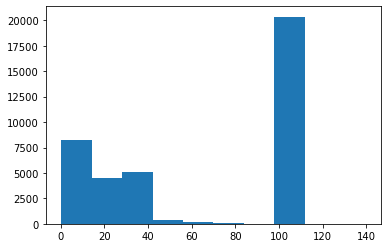

In [10]:
import matplotlib.pyplot as plt
plt.hist(df7['CPM2'])

In [23]:
df8 = df
df8.drop_duplicates(subset=['delivery_start', 'min_impressions', 'max_impressions', 'min_spend', 'max_spend', 'ad_body'])

,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,delivery_period,...,CPM,CPM2,impressions2,spend2,CPM3,facebook,instagram,messenger,audience_network,demographic_dist
0,ad-tech,US,100470349235347,Save Texas,762749274711708,2022-05-03,5,2022-05-03,2022-05-06,3,...,33.011004,19.607843,2499,99,39.615846,1,0,0,0,"[{'percentage': '0.004551', 'age': '18-24', 'g..."
1,ad-tech,US,100470349235347,Save Texas,563054608471314,2022-05-03,5,2022-05-03,2022-05-06,3,...,99.099099,98.196393,999,99,99.099099,1,0,0,0,"[{'percentage': '0.003058', 'age': '45-54', 'g..."
2,ad-tech,US,430964644347524,Campaign Ad-Cloud,930566127614072,2022-05-03,5,2022-05-03,2022-05-08,5,...,49.524762,32.688459,1499,99,66.044029,1,1,0,0,"[{'percentage': '0.001969', 'age': '25-34', 'g..."
3,ad-tech,US,143542762946146,Marcus Murphy,738864343939155,2022-04-07,4,2022-04-07,2022-04-22,15,...,49.524762,32.688459,1499,99,66.044029,1,0,0,0,"[{'percentage': '0.000834', 'age': '45-54', 'g..."
4,ad-tech,US,108510735095059,Dr. Jennifer Wilson for City Council District 5,512240050437223,2022-04-07,4,2022-04-07,2022-04-25,18,...,26.601773,27.922234,12499,349,27.922234,1,1,0,0,"[{'percentage': '0.000944', 'age': '25-34', 'g..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38865,analytics,BR,1445990532337716,ShareAmerica,240738354310133,2021-01-26,1,2021-01-27,2021-01-31,4,...,9.900990,5.158438,9499,99,10.422150,1,0,0,0,"[{'percentage': '0.528781', 'age': '18-24', 'g..."
38866,analytics,BR,1445990532337716,ShareAmerica,317299229725676,2021-01-26,1,2021-01-27,2021-01-31,4,...,6.600440,3.920314,12499,99,7.920634,1,0,0,0,"[{'percentage': '0.144393', 'age': '65+', 'gen..."
38867,analytics,BR,1445990532337716,ShareAmerica,491096738951834,2021-01-26,1,2021-01-27,2021-01-31,4,...,19.803961,10.891309,4499,99,22.004890,1,0,0,0,"[{'percentage': '0.243153', 'age': '45-54', 'g..."
38868,analytics,BR,1445990532337716,ShareAmerica,1123476751437734,2021-01-26,1,2021-01-27,2021-01-31,4,...,4.950248,2.800160,17499,99,5.657466,1,0,0,0,"[{'percentage': '0.492822', 'age': '25-34', 'g..."


In [24]:
df8 = df8[(np.abs(stats.zscore(np.log(df8['CPM2']))) < 2)]

(array([1.6137e+04, 7.4000e+02, 7.9000e+01, 2.0359e+04, 7.0000e+00,
        7.0000e+00, 0.0000e+00, 3.0000e+00, 2.0000e+00, 1.8000e+01]),
 array([  4.88004338,  34.34534124,  63.81063911,  93.27593697,
        122.74123483, 152.2065327 , 181.67183056, 211.13712842,
        240.60242629, 270.06772415, 299.53302201]),
 <BarContainer object of 10 artists>)

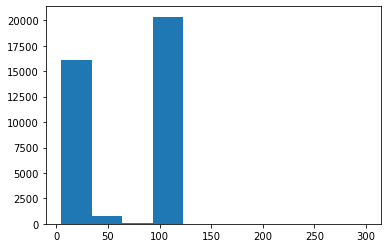

In [25]:
plt.hist(df8['CPM2'])